In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import random
import warnings
import pickle
import importlib
warnings.filterwarnings(action='ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
torch.manual_seed(1015)
# define 'device' to upload tensor in gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import sklearn
from sklearn.neighbors import KNeighborsRegressor

# 상위 폴더에서 module을 import하기 위해 시스템 경로에 상위 폴더의 경로를 추가
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 


from utils.preprocess_utils import *
from utils.train_utils import *
from models.model_cycle.cycle_lstm import LSTMModel_cycle

In [2]:
### morning data
with open('../data/preprocess/l_data_list.pkl', 'rb') as f:
#with open('data/preprocess/l_data_list.pkl', 'rb') as f:
#with open('data/preprocess/e_data_list.pkl', 'rb') as f:
#with open('data/preprocess/full_data_list.pkl', 'rb') as f:
    data_list = pickle.load(f)

#print(data_list[1].shape)
data_list = append_cycle_size(data_list)
#print(data_list[1].shape)

train_time, train_notime, train_y,\
valid_time, valid_notime, valid_y, \
    test_time, test_notime, test_y = numpy2tensor(data_list)

In [3]:
# load model
model = LSTMModel_cycle(input_size = 12, hidden_size = 32, no_time_size = 4).to(device)
# set model
criterion = nn.MSELoss(size_average = True)


train_error = []
valid_error = []

hist = {'best_val_error': 100,
        'best_val_epoch': 0}
start_epochs = 0
num_epochs = 0

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.5e-2)

run_epochs = 300
num_epochs += run_epochs
for t in range(start_epochs, num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    # model.hidden = model.init_hidden()  
    # Forward pass

    train_pred = model(train_time, train_notime)
    loss = criterion(train_pred, train_y[:,:,1])
    train_error.append(loss)

    valid_pred = model(valid_time, valid_notime)
    valid_mse = float(criterion(valid_pred, valid_y[:,:,1]).cpu())
    valid_error.append(valid_mse)
    if hist['best_val_error'] >= valid_mse:
        hist['best_val_error'] = valid_mse
        hist['best_val_epoch'] = t
        torch.save(model, 'models/best_cycles.pkl')
    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()
    

    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")

start_epochs = num_epochs
best_model = torch.load('models/best_cycles.pkl')

10 Epochs train MSE: 0.01783 // valid MSE: 0.01029
20 Epochs train MSE: 0.01654 // valid MSE: 0.00978
30 Epochs train MSE: 0.01213 // valid MSE: 0.00897
40 Epochs train MSE: 0.00820 // valid MSE: 0.00763
50 Epochs train MSE: 0.00637 // valid MSE: 0.00597
60 Epochs train MSE: 0.00535 // valid MSE: 0.00579
70 Epochs train MSE: 0.00477 // valid MSE: 0.00563
80 Epochs train MSE: 0.00434 // valid MSE: 0.00570
90 Epochs train MSE: 0.00403 // valid MSE: 0.00558
100 Epochs train MSE: 0.00375 // valid MSE: 0.00566
110 Epochs train MSE: 0.00349 // valid MSE: 0.00567
120 Epochs train MSE: 0.00324 // valid MSE: 0.00575
130 Epochs train MSE: 0.00303 // valid MSE: 0.00586
140 Epochs train MSE: 0.00285 // valid MSE: 0.00601
150 Epochs train MSE: 0.00268 // valid MSE: 0.00619
160 Epochs train MSE: 0.00254 // valid MSE: 0.00636
170 Epochs train MSE: 0.00244 // valid MSE: 0.00650
180 Epochs train MSE: 0.00236 // valid MSE: 0.00664
190 Epochs train MSE: 0.00227 // valid MSE: 0.00675
200 Epochs train MSE:

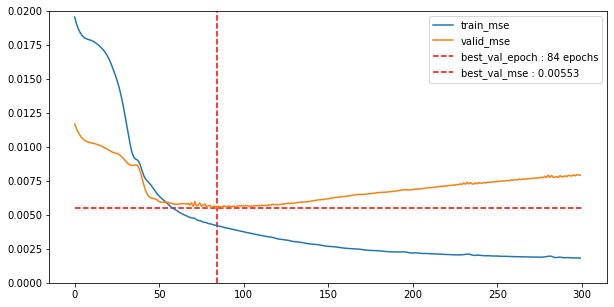

In [7]:
plt.figure(figsize = [10, 5])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.02)
plt.show()

In [5]:
print("lunch cycle results")

train_pred = best_model(train_time, train_notime)
print('train_error : ',criterion(train_pred, train_y[:,:,1]))

valid_pred = best_model(valid_time, valid_notime)
print('valid_error : ',criterion(valid_pred, valid_y[:,:,1]))

test_pred = best_model(test_time, test_notime)
print('test_error : ',criterion(test_pred, test_y[:,:,1]))

lunch cycle results
train_error :  tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>)
valid_error :  tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward>)
test_error :  tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>)


In [6]:
# cycle
i = 1
print("morning trend")
y = torch.cat((train_y[:,:,i], valid_y[:,:,i], test_y[:,:,i]))
zeros = torch.zeros_like(y).to(device)
print('zeros error : ',np.array((criterion(zeros, y)).cpu()))
rand_normal = torch.randn(y.shape).to(device)
print('random normal error : ',np.array((criterion(rand_normal, y)).cpu()))

x = torch.cat((train_time[:,-7:,(i-2)], valid_time[:,-7:,(i-2)], test_time[:,-7:,(i-2)]))
print('last week error : ',np.array(criterion(x, y).cpu()))

morning trend
zeros error :  0.01707093
random normal error :  1.019575
last week error :  0.008110794


In [ ]:

plt.figure(figsize = [10, 5])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.02)
plt.show()

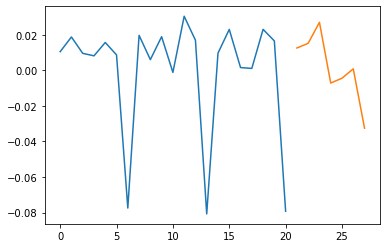

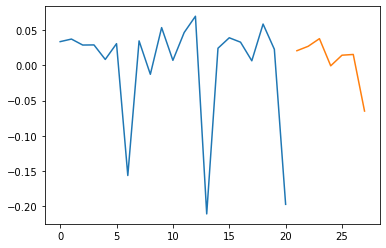

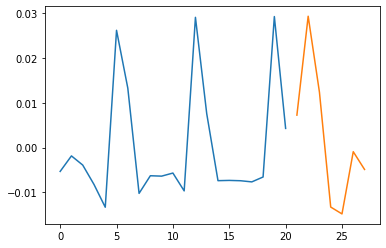

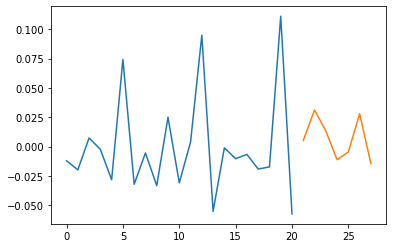

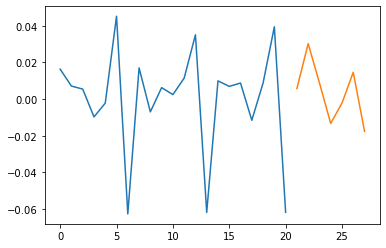

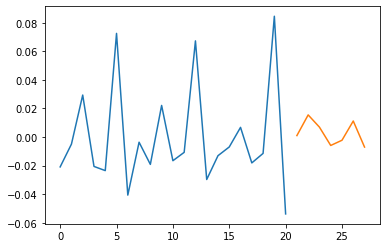

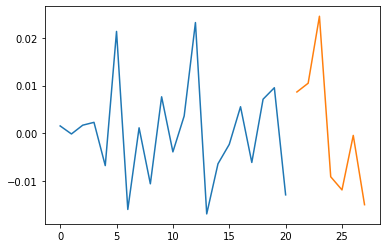

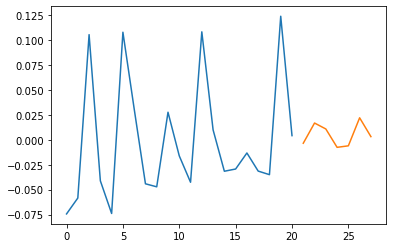

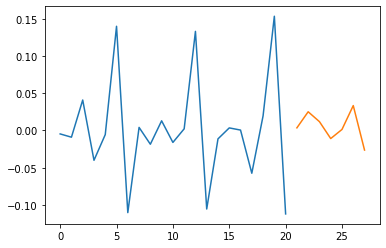

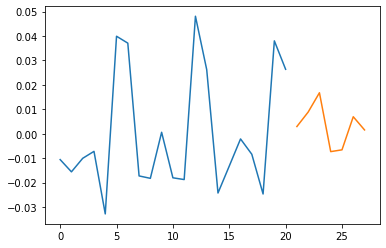

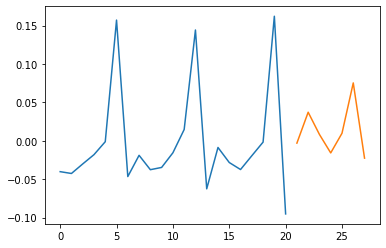

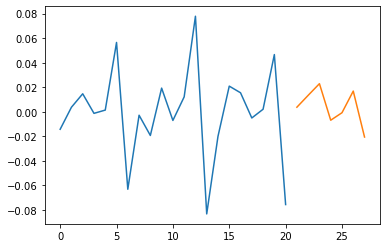

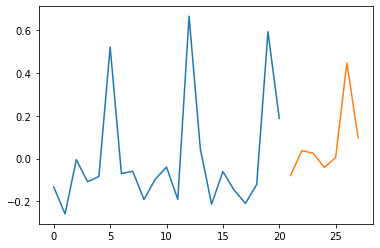

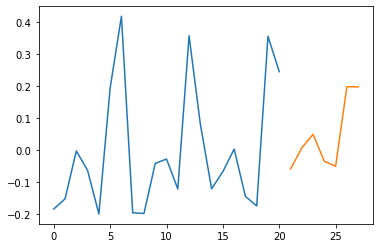

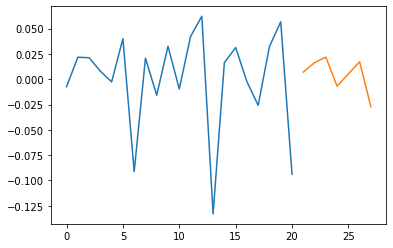

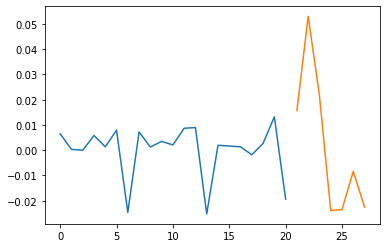

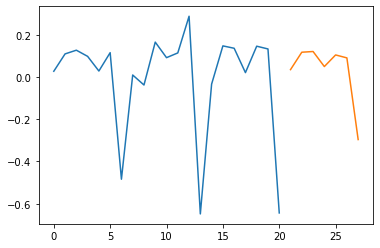

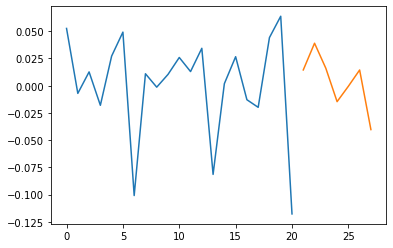

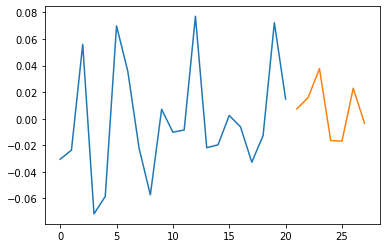

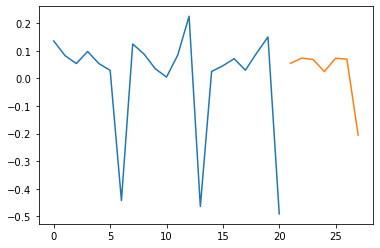

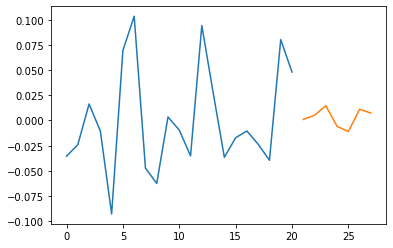

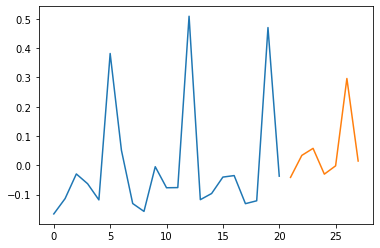

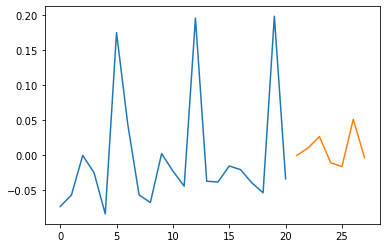

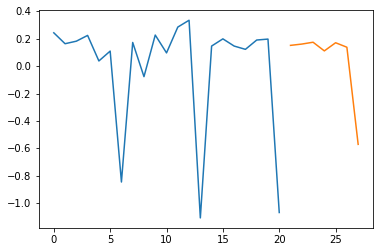

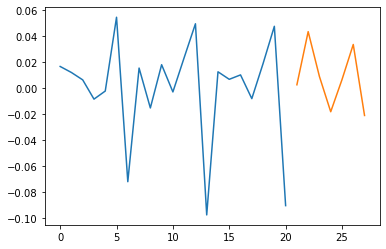

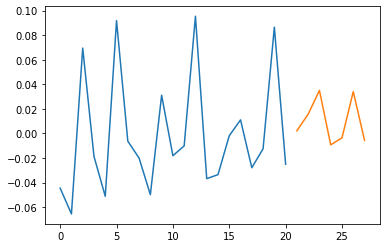

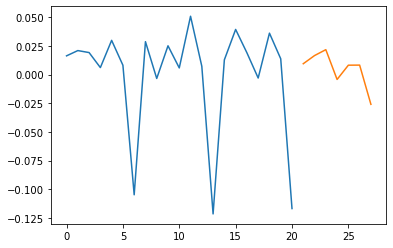

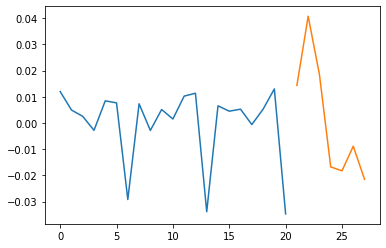

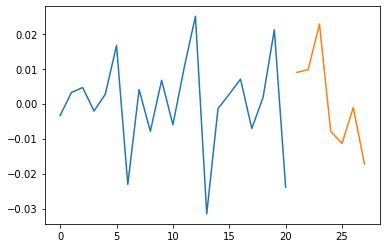

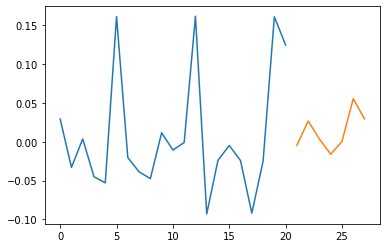

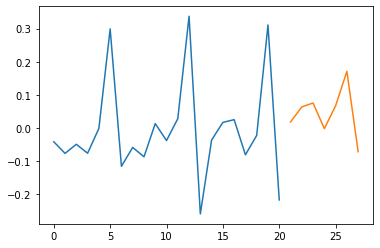

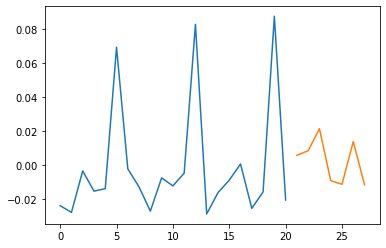

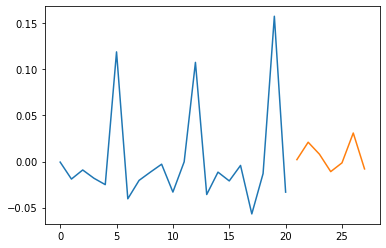

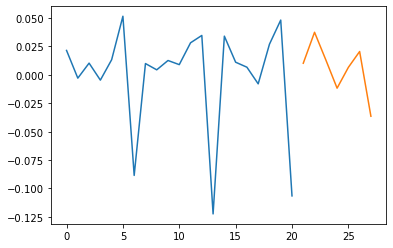

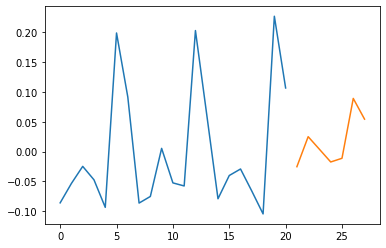

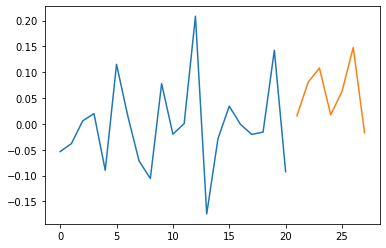

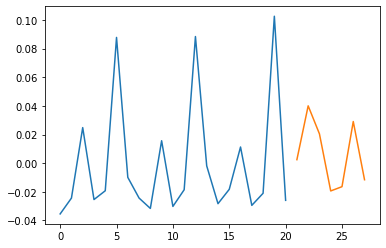

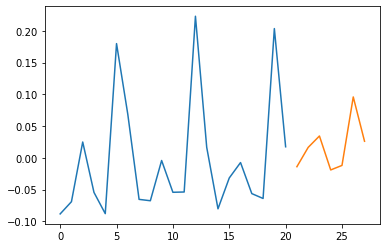

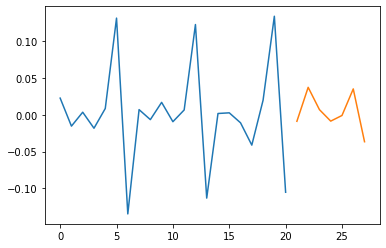

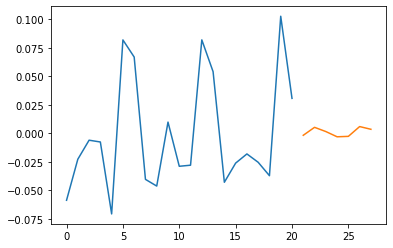

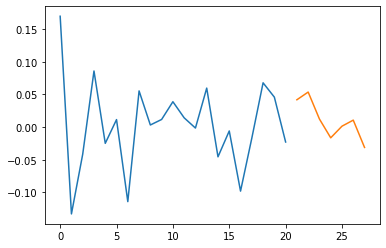

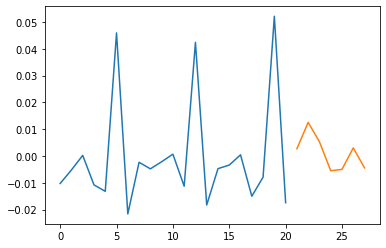

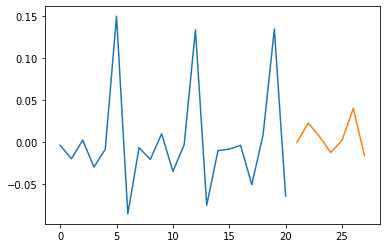

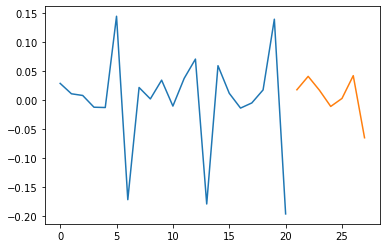

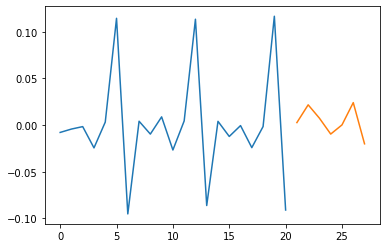

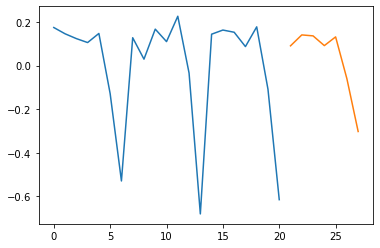

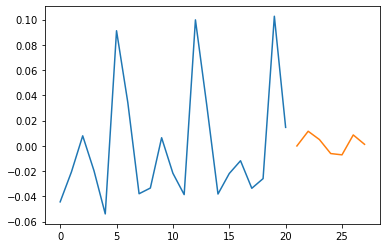

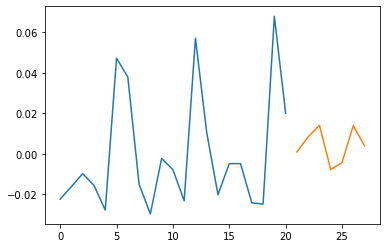

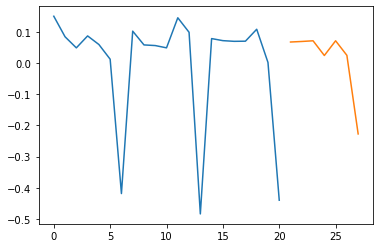

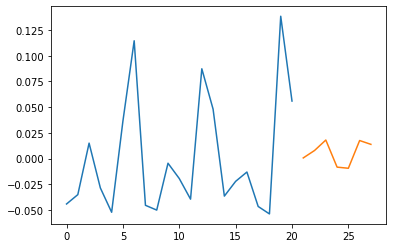

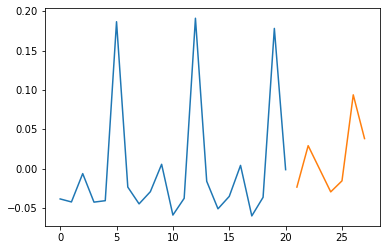

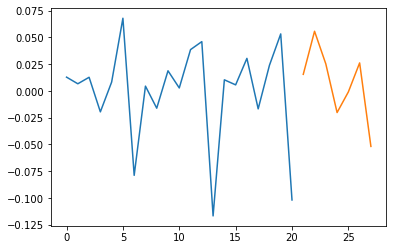

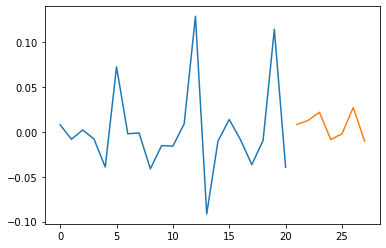

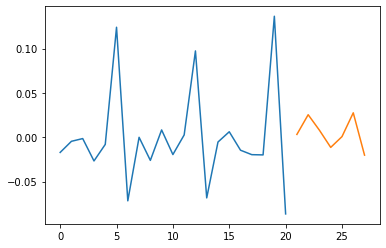

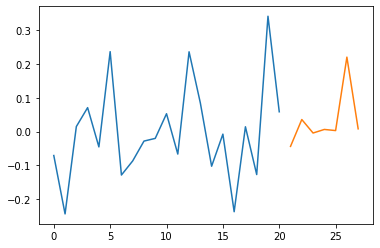

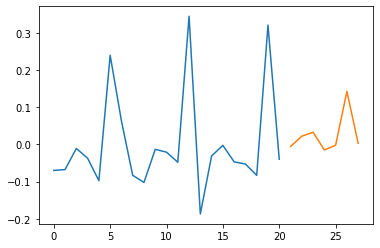

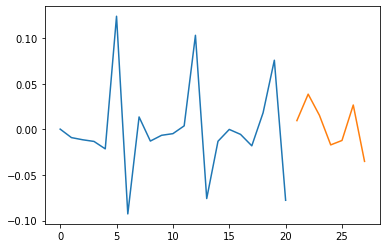

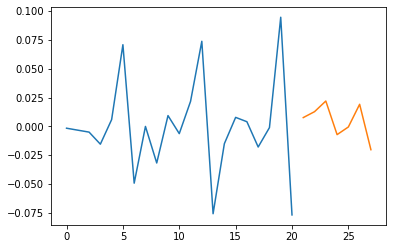

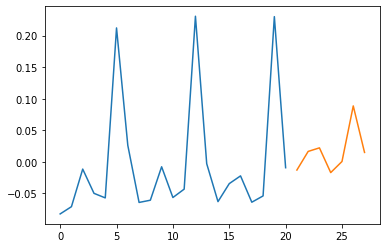

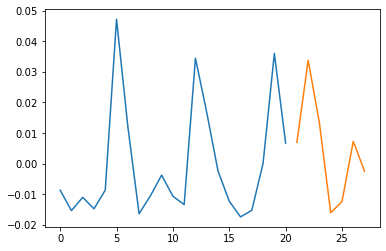

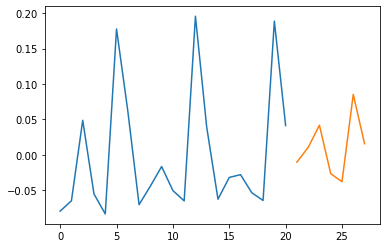

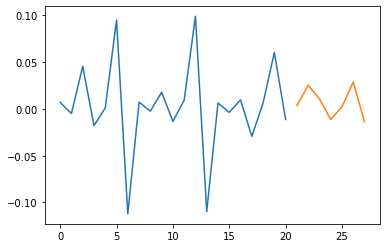

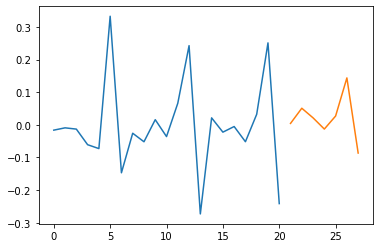

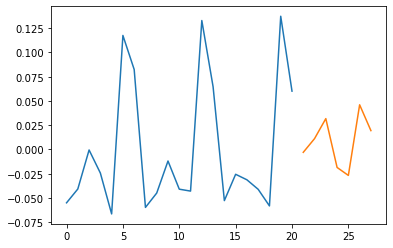

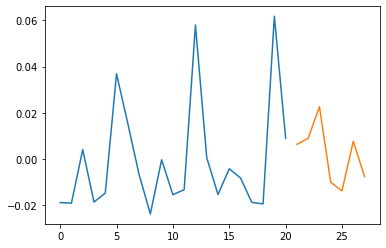

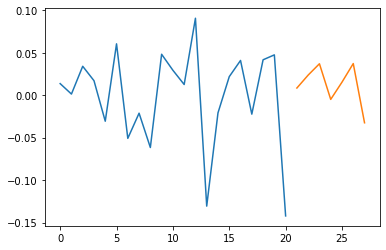

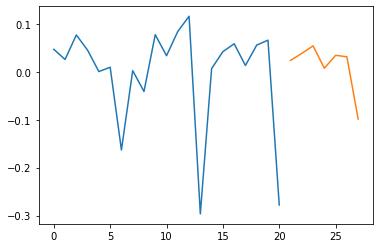

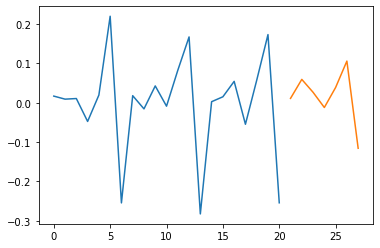

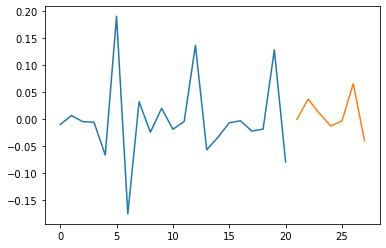

In [9]:
with open('../data/preprocess/lunch_last_time.pkl', 'rb') as f:
    train_time = pickle.load(f)
with open('../data/preprocess/lunch_last_notime.pkl', 'rb') as f:
    train_notime = pickle.load(f)

tc = 1
cycle_size =train_time[:,:,-2].max(axis = 1) - train_time[:,:, -2].min(axis = 1)
train_notime = np.concatenate([train_notime, cycle_size.reshape(-1,1)], axis = 1)

train_time_x, train_notime_x = numpy2tensor([train_time[:,:,3:].astype(np.float64), train_notime.astype(np.float64)])
pred_y = best_model(train_time_x, train_notime_x)
pred_y = np.array(pred_y.cpu().detach())

for i in range(69):
    plt.plot(np.arange(21), np.array(train_time_x[i,:,tc-2].cpu()))
    plt.plot(np.arange(21,28), pred_y[i,:])
    plt.show()

pred_y
path = '../data/preprocess/'
with open(path + 'full_lunch_cycle_pred.pkl', 'wb') as f:
    pickle.dump(pred_y, f)

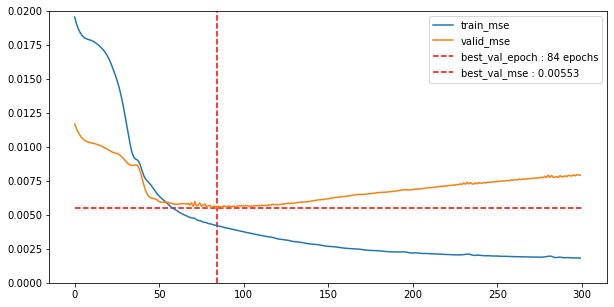

In [7]:

plt.figure(figsize = [10, 5])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.02)
plt.show()

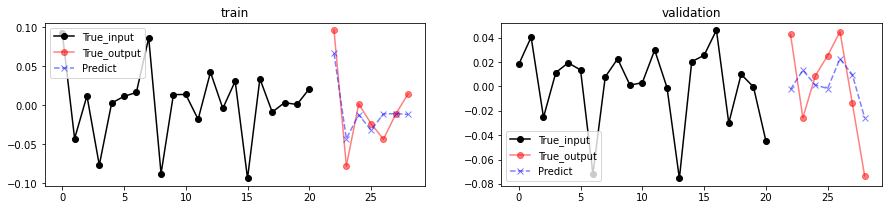

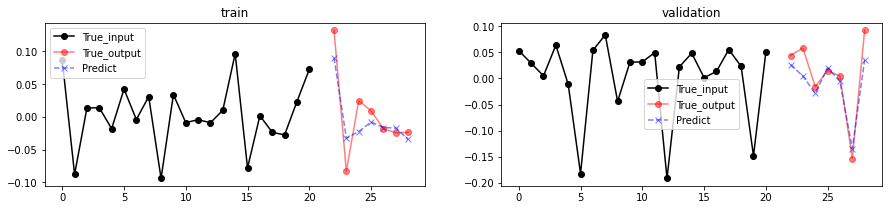

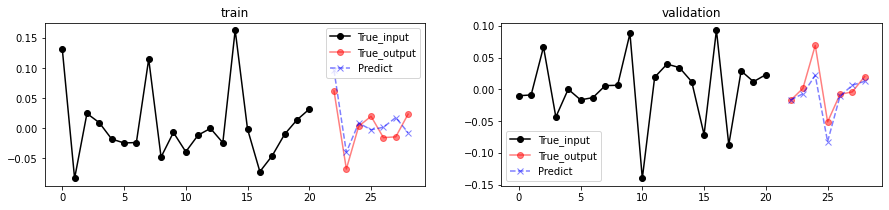

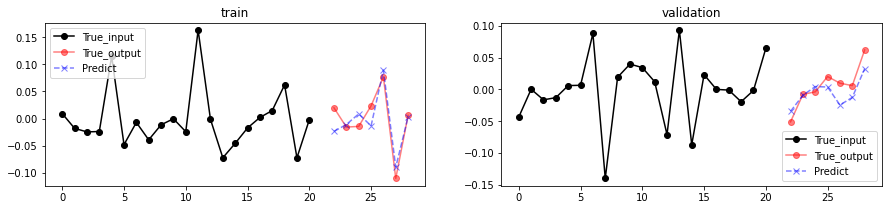

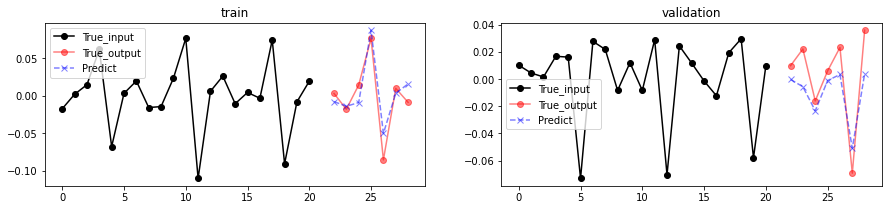

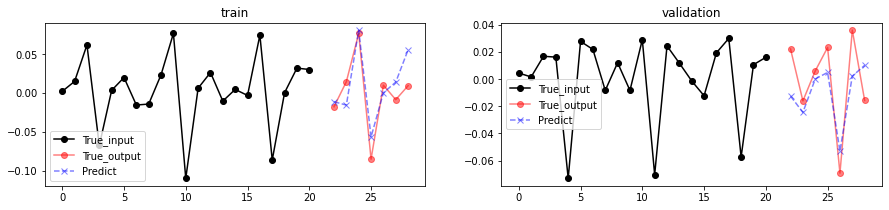

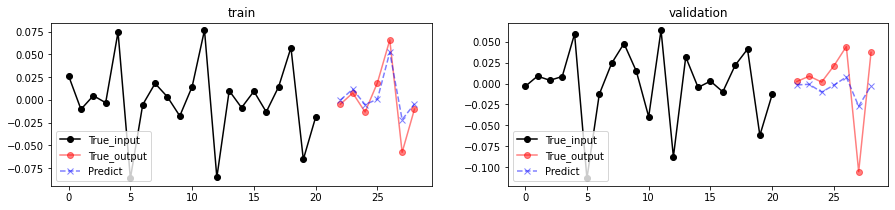

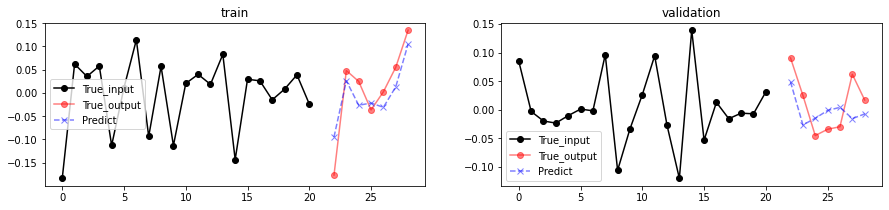

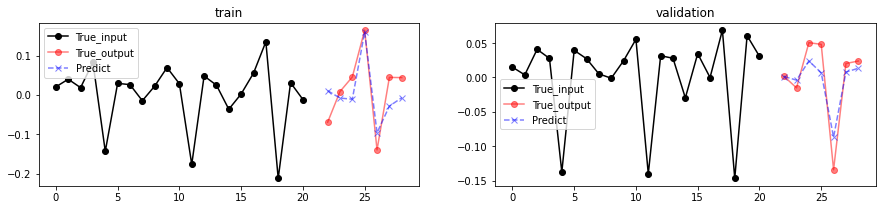

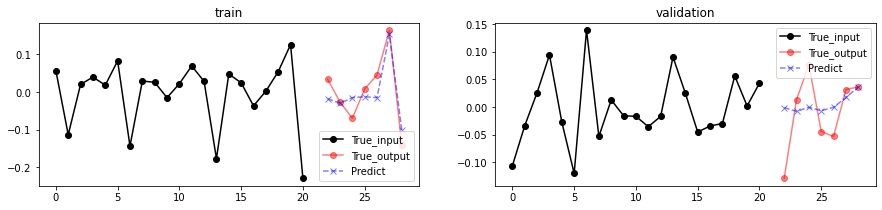

In [8]:
train_pred = best_model(train_time, train_notime)
valid_pred = best_model(valid_time, valid_notime)
# convert result
train_x_np, train_y_np, train_pred_np,\
valid_time_x_np, valid_y_np, valid_pred_np = tensor2numpy([train_time[:,:,-1], train_y[:,:,1], train_pred,
                                                        valid_time[:,:,-1], valid_y[:,:,1], valid_pred])
# plot result
plot_predict(train_x_np, train_y_np, train_pred_np,\
                valid_time_x_np, valid_y_np, valid_pred_np)

# save result
cycle_result_list = [train_x_np, train_y_np, train_pred_np,\
                    valid_time_x_np, valid_y_np, valid_pred_np]
### morning result
path = '../data/train_results/lunch_results/'
with open(path + 'l_cycle_results_list.pkl', 'wb') as f:
    pickle.dump(cycle_result_list, f)

In [7]:
test_pred = best_model(test_time, test_notime)
criterion(test_pred, test_y[:,:,1])

tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>)

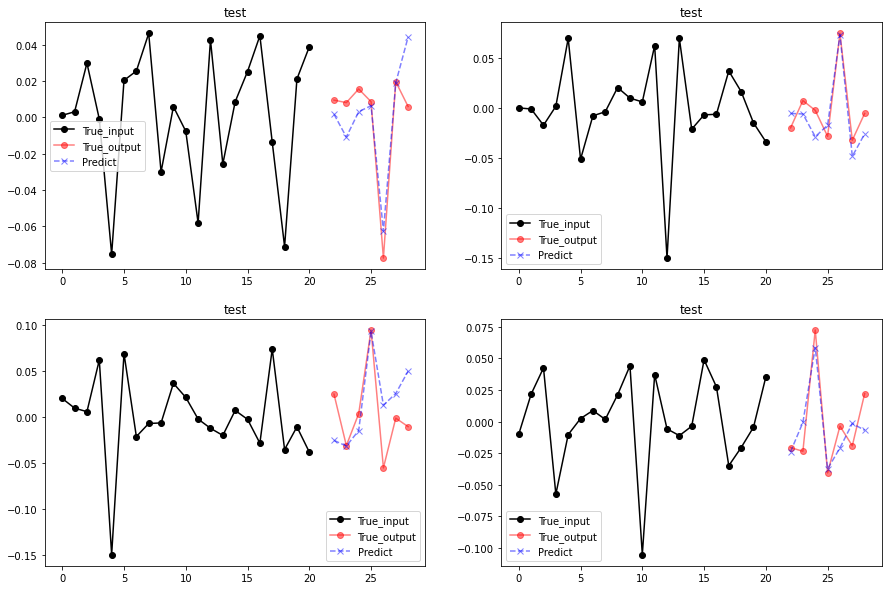

In [6]:
train_pred = best_model(train_time, train_notime)
test_pred = best_model(test_time, test_notime)
# convert result
train_x_np, train_y_np, train_pred_np,\
test_time_x_np, test_y_np, test_pred_np = tensor2numpy([train_time[:,:,-1], train_y[:,:,1], train_pred,
                                                        test_time[:,:,-1], test_y[:,:,1], test_pred])
# plot result
plot_test_predict(test_time_x_np, test_y_np, test_pred_np)

# save result
cycle_result_list = [train_x_np, train_y_np, train_pred_np,\
                    test_time_x_np, test_y_np, test_pred_np]

In [30]:
with open('../data/preprocess/lunch_last_time.pkl', 'rb') as f:
    train_time = pickle.load(f)
with open('../data/preprocess/lunch_last_notime.pkl', 'rb') as f:
    train_notime = pickle.load(f)

tc = 0
cycle_size =train_time[:,:,-2].max(axis = 1) - train_time[:,:,-2].min(axis = 1)
train_notime = np.concatenate([train_notime, cycle_size.reshape(-1,1)], axis = 1)

train_time_x, train_notime_x = numpy2tensor([train_time[:,:,3:].astype(np.float64), train_notime.astype(np.float64)])
pred_y = model(train_time_x, train_notime_x)
pred_y = np.array(pred_y.cpu().detach())

i = 1
plt.plot(np.arange(21), np.array(train_time_x[i,:,tc-1].cpu()))
plt.plot(np.arange(21,28), pred_y[i,:])

pred_y
path = '../data/preprocess/'
with open(path + 'full_lunch_cycle_pred.pkl', 'wb') as f:
    pickle.dump(pred_y, f)

RuntimeError: input.size(-1) must be equal to input_size. Expected 12, got 9